In [1]:
%%capture capt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
# from numba import njit, prange

## Import IMDB dataset

In [2]:
INDEX_FROM = 3
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)

In [3]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}

In [4]:
# print first sentence in X_train
sentence = [id_to_word[word] for word in X_train[0]]
print(' '.join(sentence))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they

## Pre-processing

In [5]:
from tensorflow.keras.preprocessing import sequence

In [6]:
mean_review_length = int(np.mean([len(x) for x in X_train]))
max_review_length = mean_review_length
print(f"Longest sequence is {max_review_length}")

Longest sequence is 238


In [7]:
X_train = sequence.pad_sequences(X_train, padding='post', maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, padding='post', maxlen=max_review_length)

## LSTM model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
nb_words = max([max(x) for x in X_train]) + 1
embedding_vector_length = 256

In [10]:
model = Sequential()
model.add(Embedding(nb_words, embedding_vector_length))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         1280000   
                                                                 
 lstm (LSTM)                 (None, None, 128)         197120    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [12]:
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), 
              metrics=['accuracy'])

In [13]:
filepath = 'model.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

callbacks = [checkpoint, 
             es
            ]

In [14]:
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/1000
195/196 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5118
Epoch 1: val_loss improved from inf to 0.69252, saving model to model.h5
196/196 [==============================] - 22s 89ms/step - loss: 0.6930 - accuracy: 0.5118 - val_loss: 0.6925 - val_accuracy: 0.5021
Epoch 2/1000
195/196 [============================>.] - ETA: 0s - loss: 0.6726 - accuracy: 0.5661
Epoch 2: val_loss improved from 0.69252 to 0.58209, saving model to model.h5
196/196 [==============================] - 16s 83ms/step - loss: 0.6724 - accuracy: 0.5663 - val_loss: 0.5821 - val_accuracy: 0.7089
Epoch 3/1000
196/196 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.8126
Epoch 3: val_loss improved from 0.58209 to 0.36773, saving model to model.h5
196/196 [==============================] - 17s 84ms/step - loss: 0.4577 - accuracy: 0.8126 - val_loss: 0.3677 - val_accuracy: 0.8470
Epoch 4/1000
195/196 [============================>.] - ETA: 0s - loss: 0.3200 -

## Visualisation semantic

In [117]:
#Ouvre le fichier qui décrit les stopwords
with open('stopwords_english.txt', 'r') as stop_words_file:
    stop_words = stop_words_file.read().splitlines()

In [118]:
from keras.preprocessing.text import Tokenizer
corpus=[]
for i in range(X_train.shape[0]):
    for word in X_train[i]:
        if id_to_word[word] not in stop_words:
            corpus.append([id_to_word[word]])

min_word_frequency = 1 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# Filter out less frequent words
word_counts = tokenizer.word_counts
tokenizer.word_index = {word: index for word, index in tokenizer.word_index.items() if word_counts[word] >= min_word_frequency}
tokenizer.word_index[tokenizer.oov_token] = len(tokenizer.word_index) + 1  # Add "unknown" token
total_words = len(tokenizer.word_index) + 1

In [119]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [120]:
model = tf.keras.models.load_model('model.h5')

['part', 'director', 'real', 'great', 'watch', 'know', 'little', 'think', 'big', 'life', 'bad', 'best', 'love', 'movies', 'seen', 'got', 'ever', 'plot', 'acting', 'funny', 'show', 'actually', 'scene', 'look', 'old', 'films', 'watching', 'first', 'going', "can't", 'man', 'way', 'better', 'actors', 'scenes', 'long', 'thought', 'nothing', 'cast', 'never', 'give', 'something', 'world', 'many', 'quite', 'interesting', 'character', 'work', 'comedy', 'new', 'want', 'pretty', 'role', 'take', 'around', 'series', 'action']


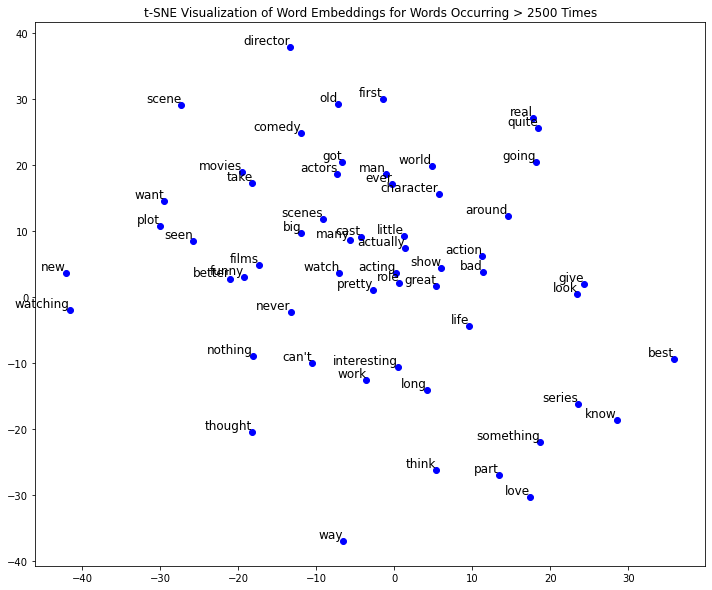

In [121]:
import matplotlib.pyplot as plt
# from TSNE_code.TSNE_utils import TSNE
from sklearn.manifold import TSNE as sk_TSNE
import numpy as np
from sklearn.metrics import pairwise_distances

#Filter words for plotting
minimum = 2500
maximum = 8000

#Je récupère ma matrice d'embedding
word_embeddings = model.layers[0].get_weights()[0]  # Your word embeddings matrix


# Apply t-SNE to reduce dimensionality to 2D
tsne = sk_TSNE(n_components=2, random_state=42, perplexity=30)
embedded_words = tsne.fit_transform(word_embeddings)

# tsne = TSNE(n_components=2, perplexity=30, adaptive_learning_rate=False, patience=50, n_iter=1000)
# embedded_words = tsne.fit_transform(word_embeddings, reference_kl_divergence=tsne.kl_divergence_,
#                                                    title='Sk-learn KL divergence', verbose=3)

# Calculate pairwise distances between embedded words
distances = pairwise_distances(embedded_words)

# Plot the t-SNE visualization with labels for the top words
plt.figure(figsize=(12, 10))

selected_words = [word for word, count in tokenizer.word_counts.items() if  maximum > count > minimum]
print(selected_words)

# Define a colormap for the selected words based on distances
# colors = plt.cm.rainbow(np.linspace(0, 1, len(selected_words)))

for i, word in enumerate(selected_words):
    index = tokenizer.word_index.get(word)
    if index is not None:
        x, y = embedded_words[index, :]
        #color = colors[i]
        plt.scatter(x, y, label=word, color='blue')
        plt.text(x, y, word, fontsize=12, ha='right', va='bottom', color='black')

plt.title(f't-SNE Visualization of Word Embeddings for Words Occurring > {minimum} Times')
# plt.legend(title='Selected Words', loc='center right', bbox_to_anchor=(1, 0.5), fontsize='large')
plt.show()


['part', 'director', 'real', 'great', 'watch', 'know', 'little', 'think', 'big', 'life', 'bad', 'best', 'love', 'movies', 'seen', 'got', 'ever', 'plot', 'acting', 'funny', 'show', 'actually', 'scene', 'look', 'old', 'films', 'watching', 'first', 'going', "can't", 'man', 'way', 'better', 'actors', 'scenes', 'long', 'thought', 'nothing', 'cast', 'never', 'give', 'something', 'world', 'many', 'quite', 'interesting', 'character', 'work', 'comedy', 'new', 'want', 'pretty', 'role', 'take', 'around', 'series', 'action']


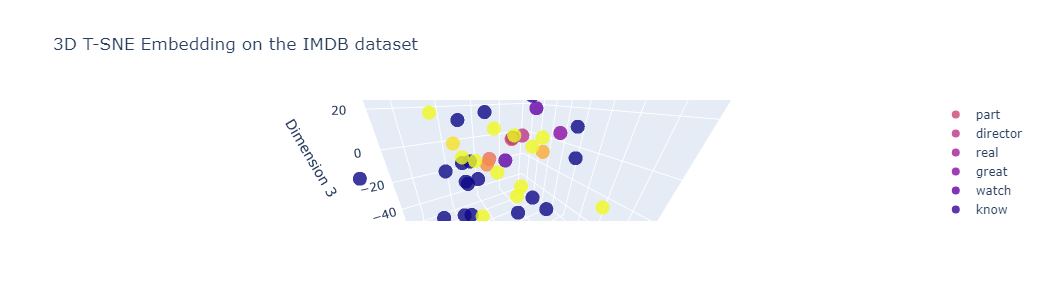

<Figure size 864x720 with 0 Axes>

In [122]:
import plotly.graph_objects as go

# Apply t-SNE to reduce dimensionality to 2D
tsne = sk_TSNE(n_components=3, random_state=42, perplexity=30)
embedded_words = tsne.fit_transform(word_embeddings)

# Calculate pairwise distances between embedded words
distances = pairwise_distances(embedded_words)

# Plot the t-SNE visualization with labels for the top words
plt.figure(figsize=(12, 10))

selected_words = [word for word, count in tokenizer.word_counts.items() if maximum > count > minimum]

# Define a colormap for the selected words based on distances
colors = plt.cm.rainbow(np.linspace(0, 1, len(selected_words)))

print(selected_words)

# Create a 3D scatter plot with plotly
fig = go.Figure()

for i, word in enumerate(selected_words):
    index = tokenizer.word_index.get(word)
    color = colors[i]
    fig.add_trace(go.Scatter3d(
        x=[embedded_words[index, 0]],
        y=[embedded_words[index, 1]],
        z=[embedded_words[index, 2]],
        text=[word],
        mode='markers',
        marker=dict(
            size=8,
            color=color, 
            opacity=0.8
        ),
        name=word
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3',
    ),
    title='3D T-SNE Embedding on the IMDB dataset'
)

# Display the plot in the notebook
fig.show()

# Save the plot as an HTML file
fig.write_html("interactive_3d_plot.html")

782/782 [==============================] - 78s 95ms/step


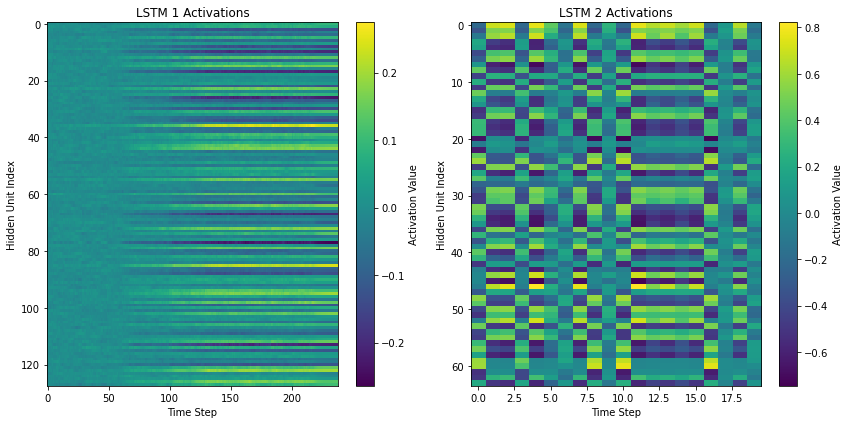

In [123]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model

# Tokenize and pad the sentences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get the activations of LSTM layers
activation_model = Model(inputs=model.input, outputs=[model.get_layer('lstm').output, model.get_layer('lstm_1').output])
lstm1_activations, lstm2_activations = activation_model.predict(X_train)


# Plot the activations with a colorbar
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(lstm1_activations[0].T, interpolation='nearest', cmap='viridis', aspect='auto')
plt.title('LSTM 1 Activations')
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit Index')
plt.colorbar(label='Activation Value')

plt.subplot(1, 2, 2)
plt.imshow(lstm2_activations[:20].T, interpolation='nearest', cmap='viridis', aspect='auto')
plt.title('LSTM 2 Activations')
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit Index')
plt.colorbar(label='Activation Value')


plt.tight_layout()
plt.show()

In [130]:
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Assuming 'word_embeddings' is your word embeddings matrix
# 'word_embeddings' should be a 2D array with dimensions (vocab_size, embedding_dim)

# Ensure all values are non-negative (replace negative values with zero)
word_embeddings_non_negative = np.maximum(word_embeddings, 0)

# Number of topics you want to extract
num_topics = 3

word_index = tokenizer.word_index

# # Create and fit NMF model
# nmf = NMF(n_components=num_topics, random_state=42)
# nmf.fit(word_embeddings_non_negative.T)

# Create and fit LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(word_embeddings_non_negative.T)

# Get the topic distributions for each word
word_topic_distributions = lda.transform(word_embeddings_non_negative.T)
# Print the top words for each topic
id_already_used_words=[]
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-word_embeddings_non_negative.shape[0]:-1]  # Get indices of top 10 words
    top_words=[]
    nb_id=0
    for id in top_words_idx:
        if not  id == 0:
            #Ici le 50 gère le nombre de mots que l'on veut dans le sujet
            if nb_id >=20:
                break
            if not id in id_already_used_words:
                top_words.append(id_to_word[id])
                id_already_used_words.append(id)
                nb_id+=1
    print(f"Topic #{topic_idx + 1}:")
    print(top_words)

Topic #1:
['wrestling', 'destroy', 'save', 'ripped', 'inane', 'villain', 'skip', 'seed', 'porno', 'avoid', 'russian', 'education', 'alright', 'advice', 'unable', 'stupid', 'boredom', 'insult', 'unless', 'dull']
Topic #2:
['worst', 'refreshing', 'flawless', 'rare', '7', 'waste', 'carrey', 'awful', 'disappointing', 'appalling', 'mst3k', 'vengeance', '8', 'courage', 'poorly', 'wonderfully', 'boring', 'wonderful', 'suspend', 'touching']
Topic #3:
['vampires', 'simpson', 'falls', 'nothing', 'grant', 'paper', 'robots', 'mental', 'moronic', 'rotten', 'tiresome', 'drags', 'cameos', 'slow', 'revenge', 'stay', 'bollywood', 'slightest', 'sat', 'miscast']
